## Notebook Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
!pip -q install --upgrade langgraph transformers peft accelerate bitsandbytes "scikit-learn==1.6.1" joblib "pandas==2.2.2" langchain-core langchain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.8/156.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 556.4/556.4 kB 35.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.4/59.4 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.5/471.5 kB 43.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.7/93.7 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.3/208.3 kB 20.3 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import re
import joblib
import json
import os
import sqlite3
import torch
from typing import TypedDict, Optional, Dict, Literal
from pydantic import BaseModel, field_validator
from math import exp
from datetime import datetime

from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver

from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModelForCausalLM, BitsAndBytesConfig
from peft import PeftModel

from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# DEFINE PATHS

BASE_PATH           = "/content/drive/MyDrive/Work/Capstone-TeamFolder/Capstone_Organized" # CHANGE THIS WHEN YOU USE THE NOTEBOOK, ENSURE THE FINAL DESTINATION IS Capstone_Organized
ML_ARTIFACT_PATH    = BASE_PATH + "/3-Model_Training/3.1-Traditional_ML/3.1.0-Traditional_ML_Artifacts"
LLM_ARTIFACT_PATH   = BASE_PATH + "/3-Model_Training/3.2-LLM_Classification/3.2.0-FineTune_OpenBioLLM"

DB_PATH             = os.path.join(BASE_PATH + "/1-Data/ED_Simulated_Database_Fixed.db")

ML_MODEL_PATH       = os.path.join(ML_ARTIFACT_PATH, "gb_model.joblib")
ML_PREPROCESSOR_PATH= os.path.join(ML_ARTIFACT_PATH, "ml_preprocessor.joblib")
ML_FEATURES_PATH    = os.path.join(ML_ARTIFACT_PATH, "ml_feature_columns.json")

LLM_MODEL_ID        = "aaditya/Llama3-OpenBioLLM-8B"
LLM_MODEL_PATH      = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Final")
LLM_OFFLOAD_PATH    = os.path.join(LLM_ARTIFACT_PATH, "OpenBioLLM_Offload")
os.makedirs(LLM_OFFLOAD_PATH, exist_ok=True)

assert os.path.exists(ML_MODEL_PATH), f"ML Model not found: {ML_MODEL_PATH}"
assert os.path.exists(ML_PREPROCESSOR_PATH), f"ML Preprocessor not found: {ML_PREPROCESSOR_PATH}"
assert os.path.exists(ML_FEATURES_PATH), f"ML Features JSON not found: {ML_FEATURES_PATH}"
assert os.path.exists(LLM_MODEL_PATH), f"LLM Checkpoint not found: {LLM_MODEL_PATH}"
assert os.path.exists(DB_PATH), f"Simulation DB not found: {DB_PATH}"

print("All model artifacts and simulation DB paths are verified.")

All model artifacts and simulation DB paths are verified.


## Load Artifacts & Define Helper Functions

In [ ]:
# LOAD ML ARTIFACTS

# Define function for joblib pointer
def clean_text_for_ml(text: str) -> str:
    """
    Cleans the *already redacted* notes for TF-IDF.
    This version removes the [AGE] tags and all non-alpha characters.
    (Copied from 3.1.1-Traditional_ML_Training.ipynb)
    """
    if not isinstance(text, str):
        return ""
    text = re.sub(r'\\[.*?\\]', ' ', text) # Remove tags like [AGE]
    text = re.sub(r'[^a-zA-Z\s]', ' ', text) # Remove special characters
    text = text.lower() # Convert to lowercase
    text = re.sub(r'\s+', ' ', text).strip() # Consolidate whitespace
    return text

# Load joblib files
ml_model = joblib.load(ML_MODEL_PATH)
ml_preprocessor = joblib.load(ML_PREPROCESSOR_PATH)

with open(ML_FEATURES_PATH, 'r') as f:
    ml_feature_names = json.load(f)

print(f"\nSuccessfully loaded ML model and preprocessor ({len(ml_feature_names)} features).")


Successfully loaded ML model and preprocessor (143 features).


In [ ]:
from peft import AutoPeftModelForSequenceClassification

classifier_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_PATH)
if classifier_tokenizer.pad_token is None:
    classifier_tokenizer.pad_token = classifier_tokenizer.eos_token

# Use AutoPeftModelForSequenceClassification to load the fine-tuned model
llm_classifier_model = AutoPeftModelForSequenceClassification.from_pretrained(
    LLM_MODEL_PATH,
    num_labels=2,
    torch_dtype=torch.float32,
    trust_remote_code=True,
    device_map="auto", # Requires a GPU!
    offload_folder=LLM_OFFLOAD_PATH
)
llm_classifier_model.eval()

print("\nSuccessfully loaded fine-tuned OpenBioLLM model.")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


pytorch_model.bin.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

pytorch_model-00002-of-00004.bin:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

pytorch_model-00001-of-00004.bin:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

pytorch_model-00003-of-00004.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

pytorch_model-00004-of-00004.bin:   0%|          | 0.00/1.17G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at aaditya/Llama3-OpenBioLLM-8B and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Successfully loaded fine-tuned OpenBioLLM model.


In [ ]:
# LOAD LLM FUSION AGENT

# 1. Configure 4-bit quantization to save memory
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,
)

# 2. Load the base model with AutoModelForCausalLM
llm_fusion_model = AutoModelForCausalLM.from_pretrained(
    LLM_MODEL_ID,
    quantization_config=bnb_config,
    trust_remote_code=True,
    device_map="auto",
)

# 3. Load its tokenizer
fusion_tokenizer = AutoTokenizer.from_pretrained(LLM_MODEL_ID, trust_remote_code=True)
if fusion_tokenizer.pad_token is None:
    fusion_tokenizer.pad_token = fusion_tokenizer.eos_token

print("\nSuccessfully loaded base OpenBioLLM *Fusion Agent* model.")

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/449 [00:00<?, ?B/s]


Successfully loaded base OpenBioLLM *Fusion Agent* model.


In [ ]:
# LOAD HELPER FUNCTIONS

# --- Helper for LLM Prediction ---
def format_for_llm_classifier(patient_data: dict) -> str:
    """Formats the raw DB row for the CLASSIFICATION model."""
    return (
        f"age range: {patient_data.get('age_bucket')} / "
        f"sex: {patient_data.get('sex')} / "
        f"heart rate: {patient_data.get('heart_rate')} / "
        f"systolic blood pressure: {patient_data.get('bp_systolic')} / "
        f"diastolic blood pressure: {patient_data.get('bp_diastolic')} / "
        f"respiratory rate: {patient_data.get('resp_rate')} / "
        f"temperature in Celsius: {patient_data.get('temperature_C')} / "
        f"oxygen saturation: {patient_data.get('oxygen_saturation')} / "
        f"ESI: {int(patient_data.get('ESI', 0))} / "
        f"recent admissions (in 30 days): {int(patient_data.get('recent_admissions_30d', 0))} / "
        f"{patient_data.get('triage_notes_redacted', '')}"
    )

def llm_predict_proba(text: str) -> float:
    """Runs the formatted text through the CLASSIFIER and returns P(Admit)."""
    device = llm_classifier_model.device
    inputs = classifier_tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = llm_classifier_model(**inputs).logits
        probs = torch.softmax(logits, dim=-1)[0]
        return float(probs[1].cpu().numpy())


# --- Helper for ML Prediction ---
def ml_predict_proba(patient_data: dict) -> float:
    """Runs the raw data through the ML preprocessor and model."""
    input_df = pd.DataFrame([patient_data])
    transformed_data = ml_preprocessor.transform(input_df)
    input_transformed_df = pd.DataFrame(transformed_data.toarray(), columns=ml_feature_names)
    prob_admit = ml_model.predict_proba(input_transformed_df)[0][1]
    return float(prob_admit)

print("Model helper functions defined.")

Model helper functions defined.


In [ ]:
def run_fusion_agent(ml_prob: float, llm_prob: float, human_note: str) -> dict:
    """
    Uses the generative LLM to synthesize inputs and make a
    final decision with rationale.
    """

    prompt = f"""<|begin_of_text|><|start_header_id|>system<|end_header_id|>
You are an expert ER triage physician. Your job is to synthesize three signals to make a final, clinically sound admission decision.

You are given three inputs:
1) p_ml:  probability of admission from a traditional ML model (strong on structured vitals).
2) p_llm: probability of admission from an LLM classifier (strong on clinical text).
3) human_note: short free-text note from a nurse or physician providing real-time context.

Your task:
- Interpret all three signals.
- Resolve disagreements between the signals.
- Produce ONE final admission decision.
- Provide ONE rationale explaining exactly WHY you chose "Admit" or "Discharge".
  * Your rationale MUST explicitly reference p_ml, p_llm, and human_note.
  * It MUST give a clear clinical justification (e.g., high risk → admit, stable symptoms → discharge).

Output STRICTLY as a single valid JSON object with EXACTLY two keys:
{{
  "decision": "Admit" | "Discharge",
  "rationale": "string (2–4 sentences explaining the reason for your decision based on p_ml, p_llm, and human_note)"
}}

Do NOT output anything else.
Do NOT add comments or markdown.
Return ONLY the JSON object.
<|eot_id|><|start_header_id|>user<|end_header_id|>
Please make a final decision based on this information:
- p_ml (ML model): {ml_prob:.2f}
- p_llm (LLM classifier): {llm_prob:.2f}
- human_note: "{human_note}"

Return ONLY the JSON object described above:
<|eot_id|><|start_header_id|>assistant<|end_header_id|>
"""

    device = llm_fusion_model.device
    inputs = fusion_tokenizer(prompt, return_tensors="pt").to(device)

    # Generate the response
    with torch.no_grad():
        outputs = llm_fusion_model.generate(
            **inputs,
            max_new_tokens=150,
            eos_token_id=fusion_tokenizer.eos_token_id
        )

    # Decode and clean the output
    response_text = fusion_tokenizer.decode(outputs[0][inputs.input_ids.shape[1]:], skip_special_tokens=True)

    # Extract the JSON part
    json_match = re.search(r'\{.*\}', response_text, re.DOTALL)
    if json_match:
        try:
            return json.loads(json_match.group(0))
        except json.JSONDecodeError:
            return {"decision": "Error", "rationale": "Failed to parse LLM JSON response."}
    else:
        return {"decision": "Error", "rationale": "No JSON object found in LLM response."}

print("Fusion helper functions defined.")

Fusion helper functions defined.


### Define Graph State

In [ ]:
class VitalSigns(BaseModel):
    """Pydantic model for validating vital signs."""
    sex: Optional[str] = None
    age_bucket: Optional[str] = None
    heart_rate: Optional[float] = None
    resp_rate: Optional[float] = None
    bp_systolic: Optional[float] = None
    bp_diastolic: Optional[float] = None
    oxygen_saturation: Optional[float] = None
    temperature_C: Optional[float] = None
    ESI: Optional[int] = None
    mental_status: Optional[str] = None
    recent_admissions_30d: Optional[int] = None


class ERState(TypedDict):
    """Defines the state of our graph."""
    visit_id: int
    human_prompt: str
    patient_data: Dict
    vitals_validated: VitalSigns
    triage_text: str
    ml_score: float
    llm_score: float
    severe: bool
    p_final: float
    decision: str
    confidence: float
    rationale: str

print("LangGraph state defined.")

LangGraph state defined.


In [ ]:
# --- Node 1: Fetch Data from DB ---
def fetch_data_node(state: ERState):
    """
    Takes a visit_id, connects to the DB, and fetches the patient's
    de-identified data from Visit_Details, Triage_Notes, and ESI.
    """
    print(f"--- 1. Fetching data for visit_id: {state['visit_id']} ---")

    conn = None
    try:
        conn = sqlite3.connect(DB_PATH)
        conn.row_factory = sqlite3.Row # Allows columns access by name

        query = """
        SELECT
            v.visit_id, v.patient_id, v.sex, v.age_bucket,
            v.heart_rate, v.bp_systolic, v.bp_diastolic, v.resp_rate,
            v.temperature_C, v.oxygen_saturation, v.recent_admissions_30d,
            v.admitted,
            t.triage_notes_redacted,
            e.ESI
        FROM Visit_Details v
        LEFT JOIN Triage_Notes t ON v.visit_id = t.visit_id AND v.patient_id = t.patient_id
        LEFT JOIN ESI e ON v.visit_id = e.visit_id AND v.patient_id = e.patient_id
        WHERE v.visit_id = ?
        """

        cursor = conn.cursor()
        cursor.execute(query, (state['visit_id'],))
        row = cursor.fetchone()

    except Exception as e:
        print(f"DB Error: {e}")
        raise
    finally:
        if conn:
            conn.close()

    if row is None:
        raise ValueError(f"No data found for visit_id: {state['visit_id']} in {DB_PATH}")

    patient_data = dict(row)

    return {
        "patient_data": patient_data,
        "vitals_validated": VitalSigns(**patient_data),
        "triage_text": patient_data.get('triage_notes_redacted', '')
    }

# --- Node 2: Severity Gate ---
def severity_gate_node(state: ERState):
    """
    Checks for any critical vital signs. (Unchanged)
    """
    print("--- 2. Checking severity gate ---")
    v = state["vitals_validated"]

    if (v.oxygen_saturation is not None and v.oxygen_saturation < 88) or \
       (v.bp_systolic is not None and v.bp_systolic < 80) or \
       (v.resp_rate is not None and (v.resp_rate > 35 or v.resp_rate < 8)):
        print(" -> CRITICAL: Patient is severe. Bypassing models.")
        return {
            "severe": True,
            "decision": "Admit",
            "p_final": 1.0,
            "rationale": "Critical vital signs detected. Bypassed ML/LLM."
        }

    print(" -> OK: Patient is not severe. Proceeding to models.")
    return {"severe": False}

In [ ]:
# --- Node 3a: ML Model ---
def ml_model_node(state: ERState):
    """
    Runs the patient data through the retrained ML pipeline.
    """
    print("--- 3a. Running ML Model ---")
    score = ml_predict_proba(state['patient_data'])
    print(f" -> ML Score (P_Admit): {score:.4f}")
    return {"ml_score": score}

# --- Node 3b: LLM Model ---
def llm_model_node(state: ERState):
    """
    Runs the patient data through the retrained LLM pipeline.
    """
    print("--- 3b. Running LLM Classifier ---")
    formatted_text = format_for_llm_classifier(state['patient_data'])
    score = llm_predict_proba(formatted_text)
    print(f" -> LLM Classifier Score (P_Admit): {score:.4f}")
    return {"llm_score": score}

# --- Node 3c: Human Input ---
def human_input_node(state: ERState):
    """
    This node simply acknowledges the human prompt.
    """
    print("--- 3c. Acknowledging Human Input ---")
    print(f" -> Human Note: '{state['human_prompt']}'")
    return {}

In [ ]:
# --- Node 4: Fusion ---
def fusion_node(state: ERState):
    """
    Uses the generative LLM (Fusion Agent) to synthesize all inputs
    and make a final, reasoned decision.
    """
    print("--- 4. Fusing Inputs with LLM Agent ---")

    p_ml = state.get("ml_score", 0.5)
    p_llm = state.get("llm_score", 0.5)
    human_note = (state.get("human_prompt") or "None").strip()

    # 1. Call the generative Fusion Agent
    agent_response = run_fusion_agent(p_ml, p_llm, human_note)

    # 2. Get decision and rationale from the agent's JSON output
    decision = agent_response.get("decision", "Error")
    rationale = agent_response.get("rationale", "No rationale provided.")

    # 3. Calculate the simple weighted score
    p_weighted = (0.7 * p_ml) + (0.3 * p_llm) # We meight the ML model better since its performance is more stable

    # If the LLM agent fails, fall back to the simple logic
    if decision == "Error":
        print(" -> LLM Fusion Agent failed. Falling back to simple weighted logic.")
        p_final = p_weighted
        decision = "Admit" if p_final >= 0.4 else "Discharge" # Use 0.4 threshold
        rationale = f"FALLBACK: {rationale}. Weighted score: {p_final:.2f}"
    else:
        # The agent's decision is primary.
        # We'll set p_final to the weighted score for analysis.
        p_final = p_weighted
        rationale = f"AGENT: {rationale} (Weighted score: {p_final:.2f})"

    print(f" -> Final P(Admit) Score: {p_final:.4f} | Agent Decision: {decision}")

    return {
        "p_final": p_final,
        "decision": decision,
        "confidence": abs(p_final - 0.5), # Confidence based on weighted score
        "rationale": rationale
    }

# --- Conditional Edge: Severity Gate ---
def conditional_severity_gate(state: ERState):
    """
    Checks the 'severe' flag to route the graph.
    """
    if state.get("severe", False):
        return "end" # Go straight to the end
    else:
        return "run_models" # Proceed to parallel branches

print("Fusion & Logic nodes defined.")

Fusion & Logic nodes defined.


## Initiate the Graph

In [ ]:
# 1. Initialize the graph
workflow = StateGraph(ERState)

# 2. *** NEW: Define a "dummy" node for parallel execution ***
# This node does nothing but act as a branching point.
def run_models_node(state: ERState):
    """
    This is a router node that triggers the parallel model runs.
    """
    print("--- 3. Fanning out to parallel models ---")
    return {}

# 3. Add all the nodes
workflow.add_node("fetch_data", fetch_data_node)
workflow.add_node("severity_gate", severity_gate_node)
workflow.add_node("run_models", run_models_node) # <-- ADD THE DUMMY NODE
workflow.add_node("ml_model", ml_model_node)
workflow.add_node("llm_model", llm_model_node)
workflow.add_node("human_input", human_input_node)
workflow.add_node("fusion", fusion_node)

# 4. Define the graph flow
workflow.set_entry_point("fetch_data")
workflow.add_edge("fetch_data", "severity_gate")

# 5. Add conditional branch
# This now correctly routes to the *string name* of our dummy node
workflow.add_conditional_edges(
    "severity_gate",
    conditional_severity_gate,
    {
        "run_models": "run_models",
        "end": END
    }
)

# 6. Define Parallel Fan-Out
# Add three separate edges *from* the dummy node
workflow.add_edge("run_models", "ml_model")
workflow.add_edge("run_models", "llm_model")
workflow.add_edge("run_models", "human_input")

# 7. Define convergence
workflow.add_edge("ml_model", "fusion")
workflow.add_edge("llm_model", "fusion")
workflow.add_edge("human_input", "fusion")

# 8. Define end
workflow.add_edge("fusion", END)

# 9. Compile
memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

print("\n--- LangGraph Compiled Successfully! ---")


--- LangGraph Compiled Successfully! ---


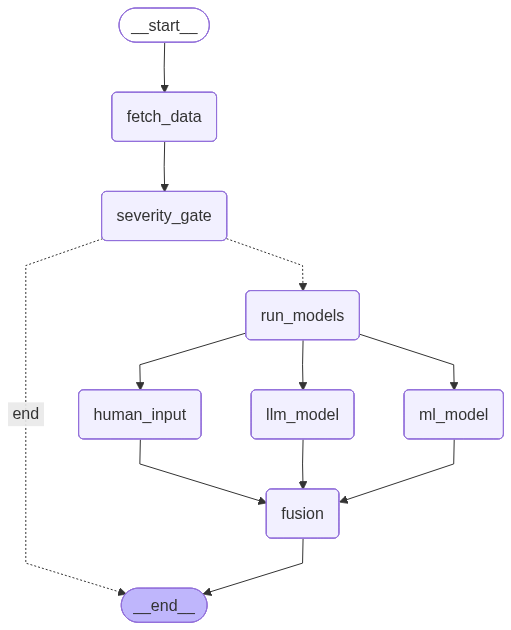

In [ ]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    print("Could not draw graph. Skipping visualization.")

## Test Run the Graph

In [ ]:
# --- Run 1: High-Risk Patient Note ---
# We'll use visit_id=1 and add a high-risk note
inputs_1 = {
    "visit_id": 1,
    "human_prompt": "Patient is 70yo, frail, and on chemotherapy."
}
config = {"configurable": {"thread_id": "sim-1"}}

print("--- Running Simulation 1 (High-Risk Note) ---")
final_state_1 = graph.invoke(inputs_1, config)

print("\n--- Final State 1 ---")
print(f"Decision: {final_state_1['decision']}")
print(f"P(Admit): {final_state_1['p_final']:.4f}")
print(f"Rationale: {final_state_1['rationale']}")


# --- Run 2: Low-Risk Patient Note ---
# We'll use visit_id=5 (assuming this is a lower-risk patient in the DB)
inputs_2 = {
    "visit_id": 5,
    "human_prompt": "Patient looks stable, likely just needs follow-up."
}
config = {"configurable": {"thread_id": "sim-2"}}

print("\n\n--- Running Simulation 2 (Low-Risk Note) ---")
final_state_2 = graph.invoke(inputs_2, config)

print("\n--- Final State 2 ---")
print(f"Decision: {final_state_2['decision']}")
print(f"P(Admit): {final_state_2['p_final']:.4f}")
print(f"Rationale: {final_state_2['rationale']}")

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


--- Running Simulation 1 (High-Risk Note) ---
--- 1. Fetching data for visit_id: 1 ---
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
--- 3. Fanning out to parallel models ---
--- 3c. Acknowledging Human Input ---
 -> Human Note: 'Patient is 70yo, frail, and on chemotherapy.'
--- 3b. Running LLM Classifier ---
--- 3a. Running ML Model ---
 -> ML Score (P_Admit): 0.8125
 -> LLM Classifier Score (P_Admit): 0.9899
--- 4. Fusing Inputs with LLM Agent ---


Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


 -> Final P(Admit) Score: 0.8657 | Agent Decision: Admit

--- Final State 1 ---
Decision: Admit
P(Admit): 0.8657
Rationale: AGENT: Due to the patient's frailty and being on chemotherapy, despite the mild symptoms, I believe it is safest to admit the patient for observation and further evaluation by specialists. The LLM classifier's high score (0.99) aligns with my clinical judgment, and the ML model's moderate score (0.81) supports the possibility of more severe underlying issues that may not be apparent yet. (Weighted score: 0.87)


--- Running Simulation 2 (Low-Risk Note) ---
--- 1. Fetching data for visit_id: 5 ---
--- 2. Checking severity gate ---
 -> OK: Patient is not severe. Proceeding to models.
--- 3. Fanning out to parallel models ---
--- 3c. Acknowledging Human Input ---
 -> Human Note: 'Patient looks stable, likely just needs follow-up.'
--- 3b. Running LLM Classifier ---
--- 3a. Running ML Model ---
 -> ML Score (P_Admit): 0.0922
 -> LLM Classifier Score (P_Admit): 0.9807


## Evaluate the Graph

To maintain consistency, we will be using the 4200-row csv dataset that was used to train/test the LLM Classifier and the ML Model. The purpose of the graph workflow above using a database is to simulate a real-world workflow. For evaluation, we will be using a csv format.

In [ ]:
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [ ]:
INPUT_CSV_PATH = os.path.join(BASE_PATH + "/1-Data/ED_Model_Training_Dataset.csv")

df_full = pd.read_csv(INPUT_CSV_PATH)
df_full = df_full.dropna().reset_index(drop=True)
print(f"Loaded {len(df_full)} rows from {INPUT_CSV_PATH}.")

In [ ]:
# PII MASKING: age

def bucket_age(a):
    """Bins the age column into categorical ranges."""
    if pd.isna(a): return None
    a = int(a)
    if a <= 17: return "0-17"
    if a <= 34: return "18-34"
    if a <= 49: return "35-49"
    if a <= 64: return "50-64"
    return "65+"

df_full["age_bucket"] = df_full["age"].apply(bucket_age)

In [ ]:
# PII MASKING: triage_notes

EMAIL_RE  = re.compile(r"\b[\w\.-]+@[\w\.-]+\.\w+\b", re.IGNORECASE)
PHONE_RE  = re.compile(r"\b(?:\+?1[-.\s]?)?(?:\(?\d{3}\)?[-.\s]?)?\d{3}[-.\s]?\d{4}\b")
SSN_RE    = re.compile(r"\b\d{3}-?\d{2}-?\d{4}\b")
DATE_RE   = re.compile(r"\b(?:\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\d{4}-\d{2}-\d{2})\b")

# Normalize unicode dashes to ASCII hyphen
DASHES = dict.fromkeys(map(ord, "\u2010\u2011\u2012\u2013\u2014\u2015"), "-")

AGE_PATTERNS = [
    re.compile(r"\b(\d{1,3})\W*(?:year|yrs?|yo|y\/?o)\W*(?:old|of\s+age)?\b", re.IGNORECASE), # Catch X-year-old, X y/o, X yrs, etc.
    re.compile(r"\bage[d]?\s*(\d{1,3})\b", re.IGNORECASE), # Catch aged X / age X
    re.compile(r"\b(in\s+(?:his|her|their|a|the)\s+)\d{2}s\b", re.IGNORECASE) # Catching decades (in his 40s)
]

# Gendered words/titles and pronouns
GENDER_RE   = re.compile(r"\b(male|female|man|woman|boy|girl|gentleman|lady|mr\.?|mrs\.?|ms\.?)\b", re.IGNORECASE)
PRONOUN_RE  = re.compile(r"\b(he|she|him|her|his|hers)\b", re.IGNORECASE)
_PRONOUN_MAP = {'he':'they','she':'they','him':'them','her':'them','his':'their','hers':'their'}

def _neutralize_pronouns(text: str) -> str:
    def _sub(m):
        src = m.group(1)
        repl = _PRONOUN_MAP[src.lower()]
        if src.isupper():     return repl.upper()
        if src[0].isupper():  return repl.capitalize()
        return repl
    return PRONOUN_RE.sub(_sub, text)

def _remove_age(m):
    """Removes the entire matched age phrase."""
    return ""

def redact_text(s):
    """Redact PII + demographics; REMOVES all numeric ages."""
    if pd.isna(s):
        return None
    t = str(s).translate(DASHES)

    # PII
    t = EMAIL_RE.sub("[EMAIL]", t)
    t = PHONE_RE.sub("[PHONE]", t)
    t = SSN_RE.sub("[SSN]", t)
    t = DATE_RE.sub("[DATE]", t)

    # Ages → REMOVE (using the aggressive patterns above)
    for rx in AGE_PATTERNS:
        # This replaces the entire matched phrase (e.g., "67-year-old") with "[AGE]"
        t = rx.sub(_remove_age, t)

    # Gendered terms and pronouns
    t = GENDER_RE.sub("the patient", t)
    t = _neutralize_pronouns(t)

    return re.sub(r"\s+", " ", t).strip()

df_full["triage_notes_redacted"] = df_full["triage_notes"].apply(redact_text)
test_note_redacted = df_full["triage_notes_redacted"].iloc[0]
print("\nOriginal Note:")
print(test_note_redacted)

In [ ]:
df_full = df_full.drop(columns=['triage_notes', 'age'])

df_full.info()

In [ ]:
TARGET_COLUMN = 'admitted'
y = df_full[TARGET_COLUMN]
X = df_full.drop(columns=[TARGET_COLUMN])

In [ ]:
_, X_test, _, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=14,
    stratify=y
)

test_patients = X_test.to_dict('records')
true_labels = y_test.tolist()

print(f"Created evaluation set with {len(test_patients)} patients.")

In [ ]:
print(f"Running Head-to-Head evaluation on {len(test_patients)} test patients...")

results = []
neutral_human_prompt = "No human note provided."

# Use tqdm for a progress bar
for i, patient_data in enumerate(tqdm(test_patients)):

    try:
        # We now have the raw patient_data dict from our CSV test set

        # --- 1. Check Severity Gate ---
        # We must run this just as the agent would
        vitals = VitalSigns(**patient_data) # Validate the data
        is_severe = (
            (vitals.oxygen_saturation is not None and vitals.oxygen_saturation < 88) or
            (vitals.bp_systolic is not None and vitals.bp_systolic < 80) or
            (vitals.resp_rate is not None and (vitals.resp_rate > 35 or vitals.resp_rate < 8))
        )

        ml_prob = 0.5
        llm_prob = 0.5
        agent_prob = 0.5
        agent_decision = 0
        agent_rationale = "N/A"

        if is_severe:
            # If the gate catches it, all systems "Admit"
            ml_prob = 1.0
            llm_prob = 1.0
            agent_prob = 1.0
            agent_decision = 1 # 1 for Admit
            agent_rationale = "Critical vital signs detected. Bypassed ML/LLM."
        else:
            # --- 2. Run Individual Models ---
            # Run ML Model (using the helper that renames age_bucket -> age_band)
            ml_prob = ml_predict_proba(patient_data)

            # Run LLM Model (using the helper that formats the string)
            llm_text = format_for_llm_classifier(patient_data)
            llm_prob = llm_predict_proba(llm_text)

            # --- 3. Run Fusion Agent Logic ---
            # We manually call the fusion_node function
            fusion_input_state = {
                "ml_score": ml_prob,
                "llm_score": llm_prob,
                "human_prompt": neutral_human_prompt
            }
            agent_state = fusion_node(fusion_input_state)
            agent_prob = agent_state['p_final']
            agent_decision = 1 if agent_state['decision'] == 'Admit' else 0
            agent_rationale = agent_state['rationale']

        # --- 4. Store all results ---
        results.append({
            'true_label': true_labels[i], # Get the matching true label
            'ml_prob': ml_prob,
            'llm_prob': llm_prob,
            'agent_prob': agent_prob,
            'ml_decision': 1 if ml_prob >= 0.4 else 0,
            'llm_decision': 1 if llm_prob >= 0.4 else 0,
            'agent_decision': agent_decision,
            'rationale': agent_rationale
        })

    except Exception as e:
        print(f"Error processing patient {i}: {e}")
        # Log error and continue
        results.append({
            'true_label': true_labels[i],
            'ml_prob': 0.5, 'llm_prob': 0.5, 'agent_prob': 0.5,
            'ml_decision': 0, 'llm_decision': 0, 'agent_decision': 0,
            'rationale': f"ERROR: {e}"
        })

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results).dropna()

print("Agent evaluation complete.")
display(results_df.head())

In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix

# Extract predictions and probabilities from the results DataFrame
agent_probabilities = results_df['agent_prob'].tolist()
agent_predictions = results_df['agent_decision'].tolist()
# Filter true_labels to match the (potentially dropped) rows in results_df
true_labels_filtered = results_df['true_label'].tolist()

# --- 1. Agent Performance (vs. True Labels) ---
print(f"--- AGENT FUSION Performance (Test Set n={len(true_labels_filtered)}) ---")

# Calculate AUC
agent_auc = roc_auc_score(true_labels_filtered, agent_probabilities)
print(f"Agent AUC: {agent_auc:.4f}")

# Classification Report
print("\nAgent Classification Report (Threshold 0.4):")
print(classification_report(true_labels_filtered, agent_predictions))

# Confusion Matrix
print("\nAgent Confusion Matrix:")
cm = confusion_matrix(true_labels_filtered, agent_predictions)
tn, fp, fn, tp = cm.ravel() # Now cm should be 2x2, raveling to 4 values
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")

# --- 2. (Optional) Create a results DataFrame to inspect ---
# This DataFrame is already created as results_df in the previous cell,
# but we can display it here for completeness if needed.
# print("\n--- Sample of Agent Decisions ---")
# display(results_df.head(10))

# print("\n--- Sample of 'Admit' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 1].head(5))

# print("\n--- Sample of 'Discharge' Decisions ---")
# display(results_df[results_df['Agent_Decision'] == 0].head(5))


In [ ]:
RESULTS_PATH = os.path.join(BASE_PATH, "5-Evaluation_Reports/agent_eval_results_playground.csv")

results_df.to_csv(RESULTS_PATH, index=False)
print(f"Results exported to: {RESULTS_PATH}")